In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [42]:
df = pd.read_csv('../../../data/processed/airport_cleaned.csv', parse_dates=['From Date'])
# df.drop("To Date", axis=1, inplace=True)
df

,From Date,NH3,SO2,CO,Ozone,Benzene,PM2.5,PM10,NO,NO2,NOx,Eth-Benzene,MP-Xylene,O,WS,WD,AT,HOUR,MONTH
0,2019-06-01 00:00:00,8.968447,12.179626,0.373962,13.710286,6.367238,17.086000,58.661489,59.723048,16.579524,76.262476,4.171932,21.877100,87.716774,1.227097,184.529677,27.810215,0,6
1,2019-06-01 01:00:00,9.016863,11.966923,0.349231,13.906923,5.444466,16.093861,51.717188,59.477379,15.399406,74.491359,4.104333,21.602857,87.869348,1.153152,187.873913,27.744130,1,6
2,2019-06-01 02:00:00,9.504804,12.471415,0.305619,13.750286,4.365825,15.659320,54.967634,56.430673,14.609010,70.510865,4.089186,21.700000,88.223226,1.124731,181.798710,27.602903,2,6
3,2019-06-01 03:00:00,9.895050,12.776481,0.294231,14.580286,2.354608,15.780962,53.554946,56.006408,13.140686,68.903107,4.638222,23.246042,88.747065,1.141848,176.929457,27.411304,3,6
4,2019-06-01 04:00:00,10.109903,13.154128,0.298302,14.143962,4.111058,14.980377,53.374362,58.782404,13.335400,71.507692,4.162989,21.476224,88.678602,1.128280,173.737204,27.353011,4,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33832,2023-04-10 16:00:00,16.350000,8.790000,1.340000,23.270000,0.000000,49.080000,237.620000,33.160000,65.450000,98.610000,2.951011,20.964353,55.900000,1.600000,298.920000,34.210000,16,4
33833,2023-04-10 17:00:00,15.030000,8.510000,1.500000,23.680000,0.000000,51.930000,219.950000,41.670000,67.010000,108.380000,2.466818,16.300814,56.030000,1.490000,299.100000,33.440000,17,4
33834,2023-04-10 18:00:00,14.860000,8.630000,1.480000,23.670000,0.000000,47.780000,205.440000,42.250000,62.510000,104.760000,2.497209,17.762558,60.160000,1.220000,298.160000,31.840000,18,4
33835,2023-04-10 19:00:00,14.690000,8.460000,1.430000,23.720000,0.000000,45.920000,185.990000,59.220000,59.860000,119.070000,2.693614,18.794824,68.800000,0.750000,279.810000,30.590000,19,4


In [43]:
# Convert the date column to a datetime object
df['From Date'] = pd.to_datetime(df['From Date'])

In [44]:
# Group the data by day and calculate the mean pollutant value
df = df.groupby(df['From Date'].dt.date).mean()

In [45]:
# Reset the index to make the date a column
daily_data = df.reset_index()

# Print the daily data
print(df)

                  NH3        SO2        CO      Ozone   Benzene      PM2.5  \
From Date                                                                    
2019-06-01  10.744882  12.154786  0.329422  15.489369  7.117549  15.991063   
2019-06-02  10.744882  12.154786  0.329422  15.489369  7.117549  15.991063   
2019-06-03  10.744882  12.154786  0.329422  15.489369  7.117549  15.991063   
2019-06-04  10.259972   9.886935  0.332388  13.230476  6.685216  15.353910   
2019-06-05  10.744882  12.154786  0.329422  15.489369  7.117549  15.991063   
...               ...        ...       ...        ...       ...        ...   
2023-04-06  15.395000   8.601250  1.430000  23.544167  4.960833  35.445833   
2023-04-07  14.011667   8.567083  1.586667  23.585417  5.168750  48.565417   
2023-04-08  16.215833   8.561667  2.382500  23.762917  2.957083  64.887917   
2023-04-09  15.990833   8.525417  1.930833  23.575417  0.000000  48.822083   
2023-04-10  14.049048   8.612857  1.643810  23.437619  0.000000 

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(df['CO'].values.reshape(-1, 1))

In [47]:
train_size = int(len(data) * 0.9)
train_data, test_data = data[:train_size,:], data[train_size:,:]

In [48]:
# Create the training and testing datasets
def create_dataset(dataset, time_steps=1):
    X, Y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        Y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(Y)

In [49]:
time_steps = 5
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

In [50]:
X_train

array([[0.1002806 , 0.1002806 , 0.1002806 , 0.10118353, 0.1002806 ],
       [0.1002806 , 0.1002806 , 0.10118353, 0.1002806 , 0.11269051],
       [0.1002806 , 0.10118353, 0.1002806 , 0.11269051, 0.11060375],
       ...,
       [0.30187226, 0.4167719 , 0.5490315 , 0.51712048, 0.38926069],
       [0.4167719 , 0.5490315 , 0.51712048, 0.38926069, 0.28769705],
       [0.5490315 , 0.51712048, 0.38926069, 0.28769705, 0.33062066]])

In [51]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', run_eagerly=True)

In [52]:
history = model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=1, validation_data=(X_test, y_test))

Epoch 1/5
20/20 [==============================] - 2s 76ms/step - loss: 0.0412 - val_loss: 0.0185
Epoch 2/5
20/20 [==============================] - 1s 67ms/step - loss: 0.0128 - val_loss: 0.0281
Epoch 3/5
20/20 [==============================] - 1s 68ms/step - loss: 0.0078 - val_loss: 0.0224
Epoch 4/5
20/20 [==============================] - 1s 67ms/step - loss: 0.0068 - val_loss: 0.0213
Epoch 5/5
20/20 [==============================] - 1s 65ms/step - loss: 0.0066 - val_loss: 0.0207


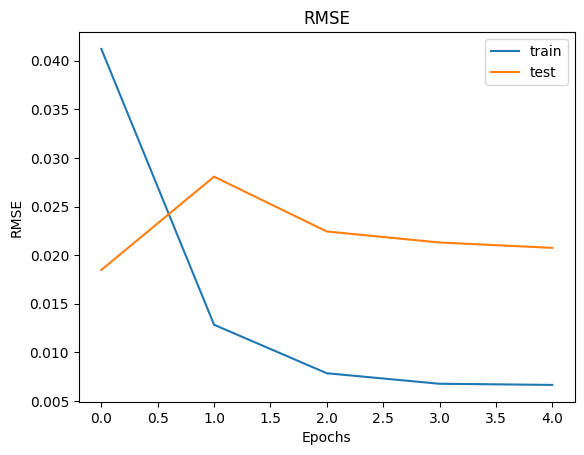

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [54]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])


5/5 [==============================] - 0s 22ms/step


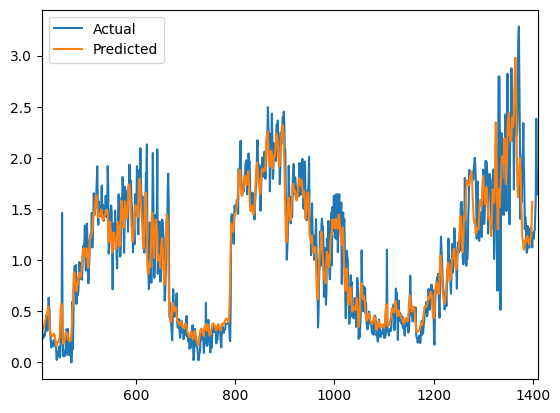

In [55]:
import matplotlib.pyplot as plt
plt.plot(df['CO'].values, label='Actual')
plt.plot(np.concatenate([train_predictions, test_predictions]), label='Predicted')
plt.xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
plt.legend()
plt.show()

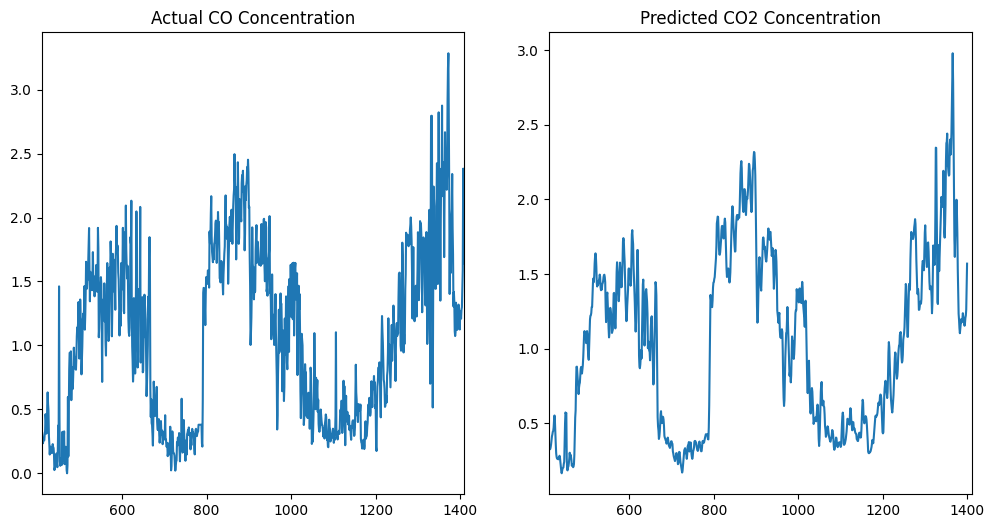

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(df['CO'].values)
ax1.set_title('Actual CO Concentration')
# show last 1000 points
ax1.set_xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
ax2.plot(np.concatenate([train_predictions, test_predictions]))
# show last 1000 points
ax2.set_xlim([len(df['CO'].values)-1000, len(df['CO'].values)])
ax2.set_title('Predicted CO2 Concentration')

plt.show()
